In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import seaborn as sns
import networkx as nx

from src.preprocessing import WikispeediaData
from src.analysis_helpers import *
from src.plot_functions import *
from src.hubs_analysis import *
from src.pagerankVSfreqeuency import *
from src.fork import *

In [2]:
sns.set_theme() 

### Reading data
Reading data and preprocessing it in WikispeediaData class

In [3]:
#Takes some time to run!
data = WikispeediaData()

data.count_articles()

### Overview of data

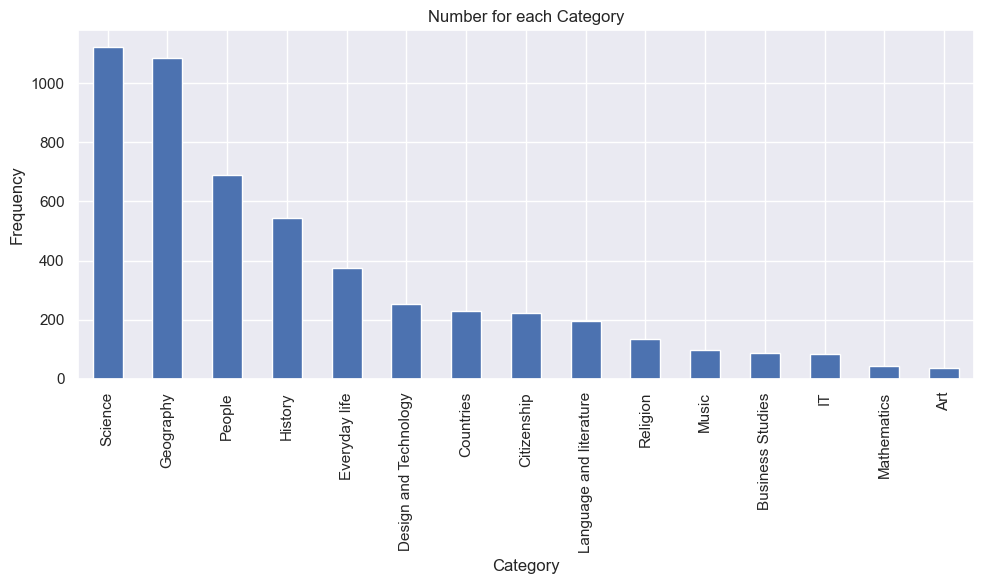

In [4]:
fig, ax = plt.subplots(1, figsize=(10, 6))
data.categories['1st cat'].value_counts().plot(kind='bar', ax=ax, title="Number for each Category")

ax.set_xlabel("Category")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Analysing hubs

In [5]:
df_hubs = get_hubs_dataframe(data)

In [6]:
#Printing statistics for dataframe
df_hubs[['source_counts', 'target_counts','mean_shortest_path_to_article','mean_shortest_path']].describe()

,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path
count,4604.000000,4604.000000,4604.000000,4604.000000
mean,26.038662,26.038662,2.829412,3.188769
std,24.201491,62.746827,1.170888,0.321702
min,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,2.626172,3.025154
50%,19.000000,8.000000,2.989640,3.179408
75%,33.000000,25.000000,3.476390,3.344081
max,294.000000,1551.000000,6.866085,5.119852


### Plotting distributions 
Plotting distributions of number of links in articles, number of links to articles, categories, mean shortest path distance from articles, mean shorest distance to article. 

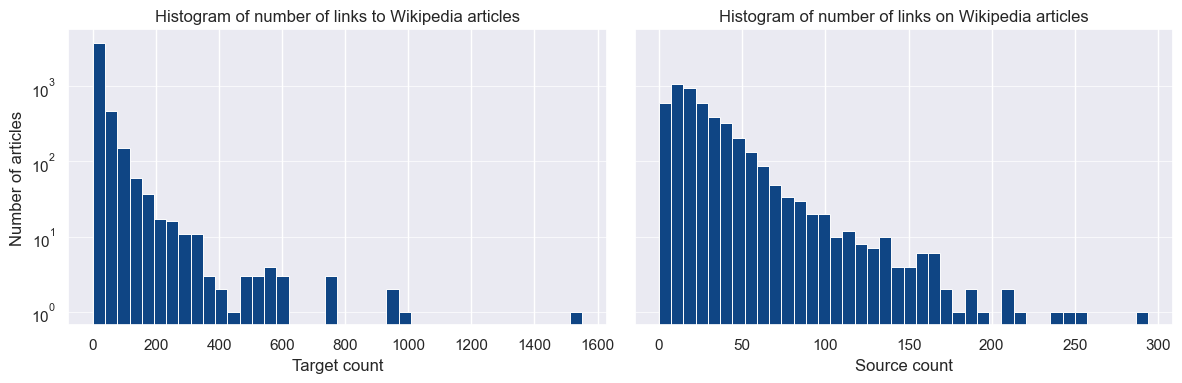

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for target_counts
sns.histplot(data=df_hubs, x="target_counts", bins=40, kde=False, ax=ax[0], color="#0f4584", alpha = 1)
ax[0].set_title('Histogram of number of links to Wikipedia articles')
ax[0].set_xlabel('Target count')
ax[0].set_ylabel('Number of articles')
ax[0].set_yscale('log')  # Set y-axis to log scale
ax[0].grid(True, axis='y', color='white', linestyle='-', linewidth=0.5) 

# Plot for source_counts
sns.histplot(data=df_hubs, x="source_counts", bins=40, kde=False, ax=ax[1], color="#0f4584", alpha = 1)
ax[1].set_title('Histogram of number of links on Wikipedia articles')
ax[1].set_xlabel('Source count')
ax[1].set_ylabel('Number of articles')
ax[1].set_yscale('log')  # Set y-axis to log scale
ax[1].grid(True, axis='y', color='white', linestyle='-', linewidth=0.5)

plt.tight_layout()

# Show the combined plot
plt.show()

# Save the combined plot as an image
fig.savefig("combined_histograms_links.png")

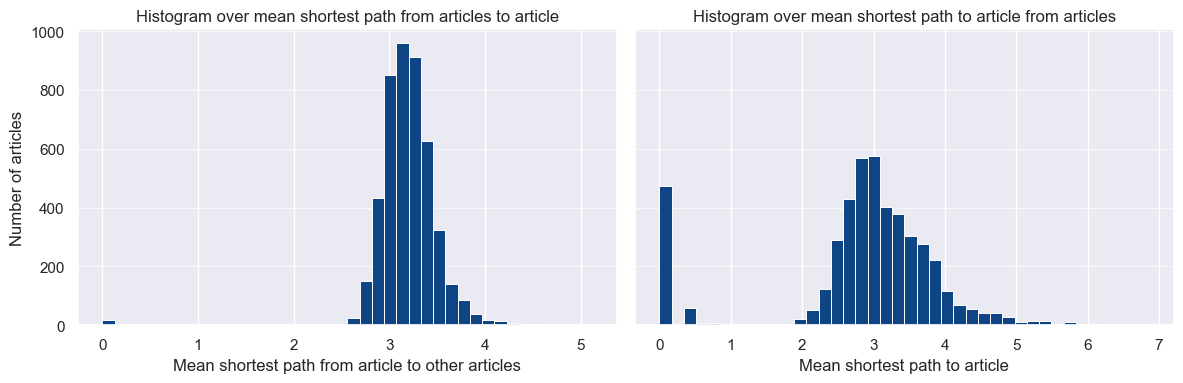

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.histplot(data=df_hubs, x="mean_shortest_path", bins=40, kde=False, ax=ax[0], color="#0f4584", alpha = 1)
ax[0].set_title('Histogram over mean shortest path from articles to article')
ax[0].set_xlabel('Mean shortest path from article to other articles')
ax[0].set_ylabel('Number of articles')
ax[0].grid(True, axis='y', color='white', linestyle='-', linewidth=0.5) 

sns.histplot(data=df_hubs, x="mean_shortest_path_to_article", bins=40, kde=False, ax=ax[1], color="#0f4584", alpha = 1)
ax[1].set_title('Histogram over mean shortest path to article from articles')
ax[1].set_xlabel('Mean shortest path to article')
ax[1].grid(True, axis='y', color='white', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

fig.savefig("combined_histograms_shortest_path.png")

### Looking at some extreme values

In [9]:
min_indices = df_hubs[df_hubs["mean_shortest_path"] < 1].index
article_names_at_min_indices = df_hubs["article_names"].iloc[min_indices]
print(f'Number of articles with min distance {len(article_names_at_min_indices)}')

df_hubs_filtered = df_hubs.drop(min_indices)

top_10_shortest_path = df_hubs_filtered.nsmallest(15, 'mean_shortest_path')[['article_names', 'mean_shortest_path']]

print('Articles with mean shortest path to other articles:')
print(top_10_shortest_path)

Number of articles with min distance 19
Articles with mean shortest path to other articles:
                     article_names  mean_shortest_path
4297                 United States            2.484834
39                    21st century            2.563502
1989          History of the world            2.578792
331                      Argentina            2.586436
24                    19th century            2.596054
4293                United Kingdom            2.606165
1247  Driving on the left or right            2.609467
128                         Africa            2.622935
3966                      Swastika            2.626387
1694                       Germany            2.626880
2433                       Lebanon            2.645376
4424                         Water            2.647842
1433                        Europe            2.648335
694                 British Empire            2.649075
2177                        Israel            2.649322


In [10]:
#Looking at values which have mean shortest path 0
min_value = df_hubs["mean_shortest_path"].min()

min_indices = df_hubs["article_names"].index[df_hubs["mean_shortest_path"] == min_value].tolist()

print('Articles with min distance', min_value)
df_hubs["article_names"].iloc[min_indices]

Articles with min distance 0.0


441                                                Badugi
970                                Color Graphics Adapter
1210                                          Directdebit
1231                                             Donation
1237                                         Douglas DC-4
1257                          Duchenne muscular dystrophy
2351                               Klinefelter's syndrome
2530                                      Local community
2543                                Lone Wolf (gamebooks)
3108                                         Osteomalacia
3352                                     Private Peaceful
3645                                        Schatzki ring
3928                                          Suikinkutsu
4289                                Underground (stories)
4333                                           Vacutainer
4480    Wikipedia Text of the GNU Free Documentation L...
4545                                          Wowpurchase
Name: article_

### Some basic plots exploring the data 

In [11]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path,Art,Business Studies,Citizenship,Countries,Design and Technology,Everyday life,Geography,History,IT,Language and literature,Mathematics,Music,People,Religion,Science
0,Áedán mac Gabráin,11,0,0.0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Åland,19,0,0.0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,Édouard Manet,20,0,0.0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Éire,8,0,0.0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Óengus I of the Picts,10,0,0.0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


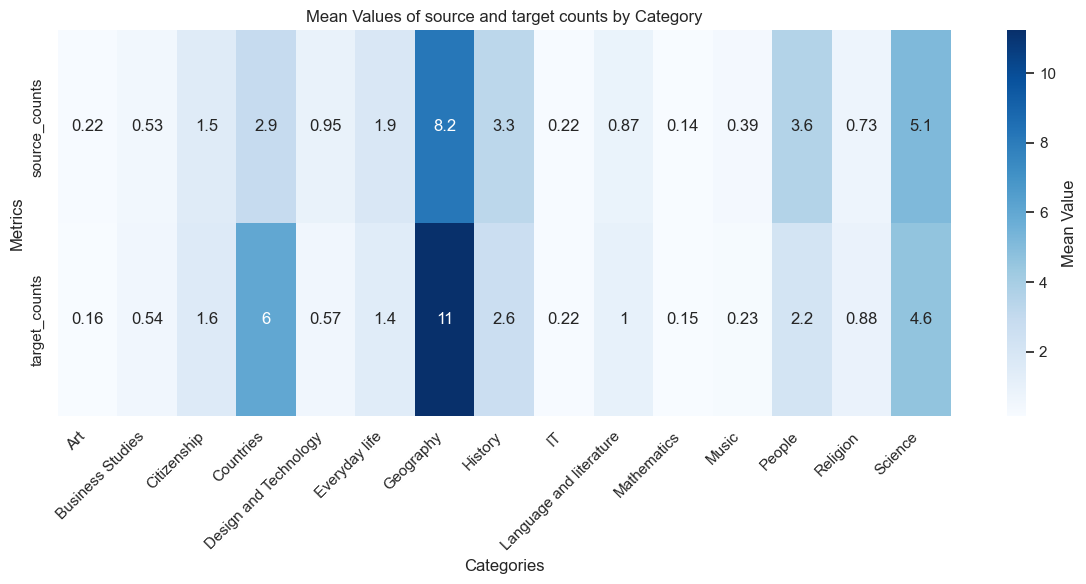

In [12]:
mean_values = df_hubs[["source_counts", "target_counts"]].mean()
categories = df_hubs.columns[5:20]

# Create matrix for plotting
matrix = pd.DataFrame({
    "source_counts": df_hubs[categories].multiply(df_hubs["source_counts"], axis=0).mean(),
    "target_counts": df_hubs[categories].multiply(df_hubs["target_counts"], axis=0).mean()}).T

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, cmap="Blues", cbar_kws={'label': 'Mean Value'})
plt.title('Mean Values of source and target counts by Category')
plt.xlabel('Categories')
plt.ylabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
#Looked at correlation between variables not sure if this is relevant to our analysis?
correlation_matrix = df_hubs[['source_counts','target_counts','mean_shortest_path_to_article','mean_shortest_path']].corr()

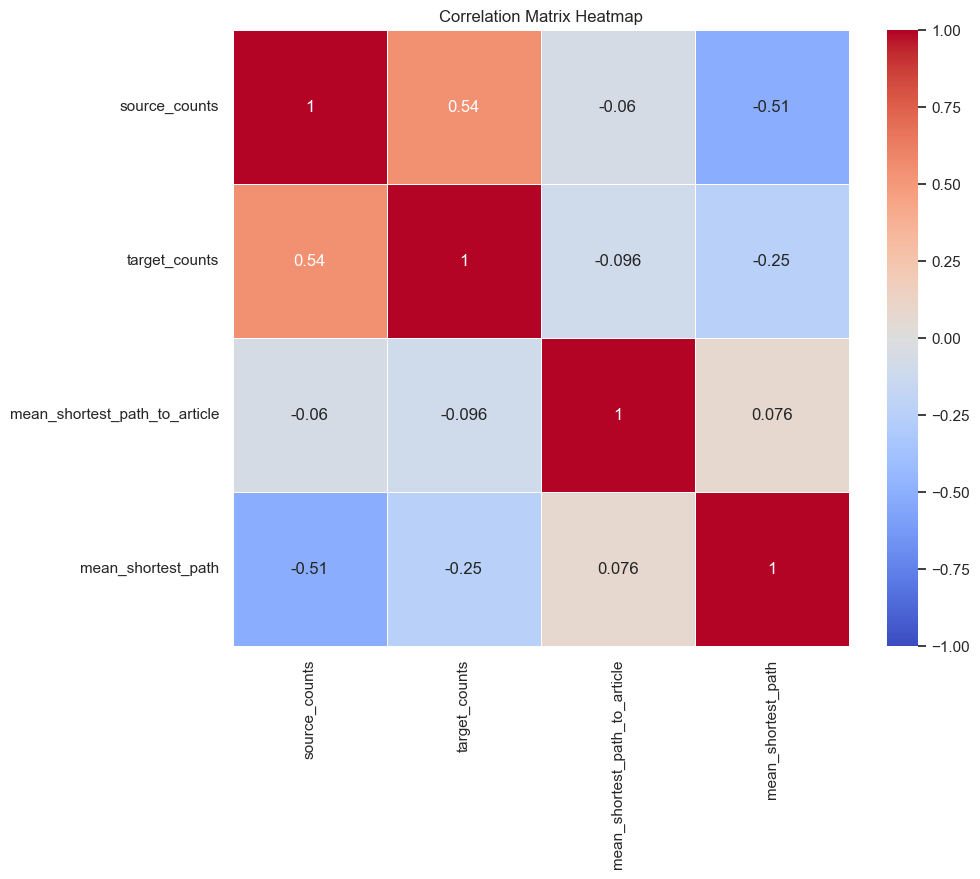

In [14]:
correlation_matrix = df_hubs[['source_counts','target_counts','mean_shortest_path_to_article','mean_shortest_path']].corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

#### Implement PageRank

In [15]:
# call PageRank functions
df_hubs = calculate_pagerank(data, df_hubs)
df_hubs = calculate_outgoing_pagerank(data, df_hubs)
df_hubs, df_filtered_hubs = create_hub_score(df_hubs)

PageRank values represent the probability that a random internet surfer will land on that node/page. So the sum of the pagerank value for all the nodes is 1. As expected, the top values are United States, France, and Europe. 

In [19]:
df_filtered_hubs["pagerank_hub_score_percent"] = df_filtered_hubs["hub_score"] * 100

In [20]:
cols = ['source_counts','target_counts','mean_shortest_path_to_article','mean_shortest_path', 'pagerank_hub_score_percent']

p_values , correlation_matrix = calculate_correlation(df_filtered_hubs, cols)

print("p-values for correlation")
print(p_values)

p-values for correlation
[[0.00000000e+000 5.48709306e-320 7.73751945e-126 0.00000000e+000
  0.00000000e+000]
 [5.48709306e-320 0.00000000e+000 2.32898918e-130 3.81665358e-089
  0.00000000e+000]
 [7.73751945e-126 2.32898918e-130 0.00000000e+000 1.28800287e-099
  5.73205902e-155]
 [0.00000000e+000 3.81665358e-089 1.28800287e-099 0.00000000e+000
  5.13716365e-100]
 [0.00000000e+000 0.00000000e+000 5.73205902e-155 5.13716365e-100
  0.00000000e+000]]


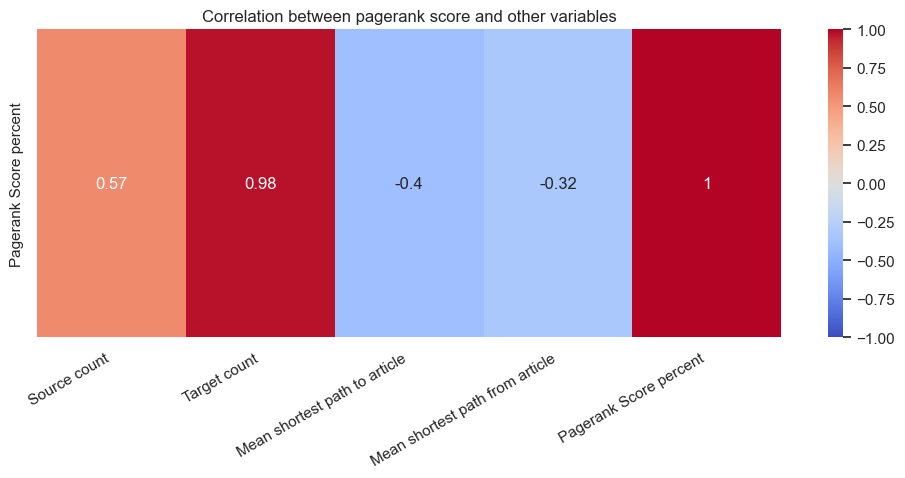

In [21]:
df_hubs_corr = df_filtered_hubs[cols].corr()
df_hubs_corr.rename(columns={'pagerank_hub_score_percent': 'Pagerank Score percent'}, inplace=True)
df_hubs_corr.rename(index={'pagerank_hub_score_percent': 'Pagerank Score percent', 
                           'source_counts': 'Source count', 'target_counts': 'Target count',
                           'mean_shortest_path': 'Mean shortest path from article','mean_shortest_path_to_article': 'Mean shortest path to article'}, inplace=True)

plt.figure(figsize=(12,4))
corr_figure = sns.heatmap(df_hubs_corr[['Pagerank Score percent']].T,
            vmin=-1,
            cmap='coolwarm',
            annot=True)

plt.xticks(rotation=30, ha='right')
plt.title('Correlation between pagerank score and other variables')
plt.savefig("corr_figure.png")

Highly correlated with target counts, and source counts, negatively correlated with mean shortest path and mean shortest path to article.

In [22]:
df_filtered_hubs["pagerank_hub_score_percent"].describe()

count    4135.000000
mean        0.023906
std         0.046008
min         0.001800
25%         0.004707
50%         0.009930
75%         0.024341
max         0.947544
Name: pagerank_hub_score_percent, dtype: float64

In [23]:
#score sums to 1
np.sum(df_filtered_hubs["pagerank_hub_score_percent"])

np.float64(98.85092621013601)

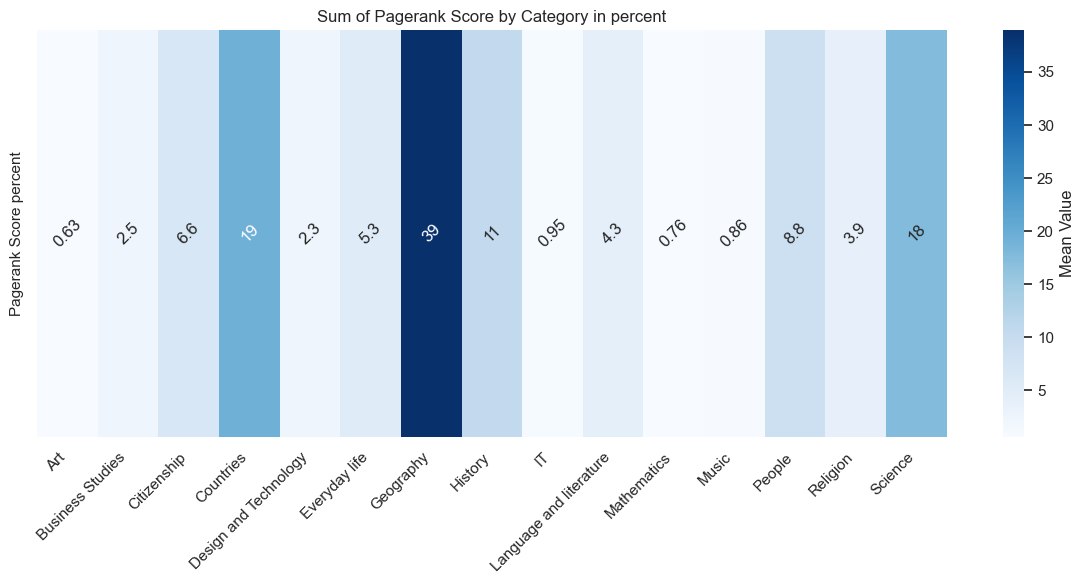

In [24]:
# Look at categories of information
mean_values = df_filtered_hubs[["pagerank_hub_score_percent"]].mean()
categories = df_filtered_hubs.columns[5:20]

# Create matrix for plotting
matrix = pd.DataFrame({
    "Pagerank Score percent": df_filtered_hubs[categories].multiply(df_filtered_hubs["pagerank_hub_score_percent"], axis=0).sum()}).T
# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, cmap="Blues", cbar_kws={'label': 'Mean Value'}, annot_kws={'rotation': 45})
plt.title('Sum of Pagerank Score by Category in percent')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("sum_pagerank_hub_score_percent.png")
plt.show()



Geography is the most important category. Has highest page rank score, then countries, then science.

#Calculate page rank score of connected articles. So what is the sum of the page rank score to other articles?

# Pagerank vs user frequency

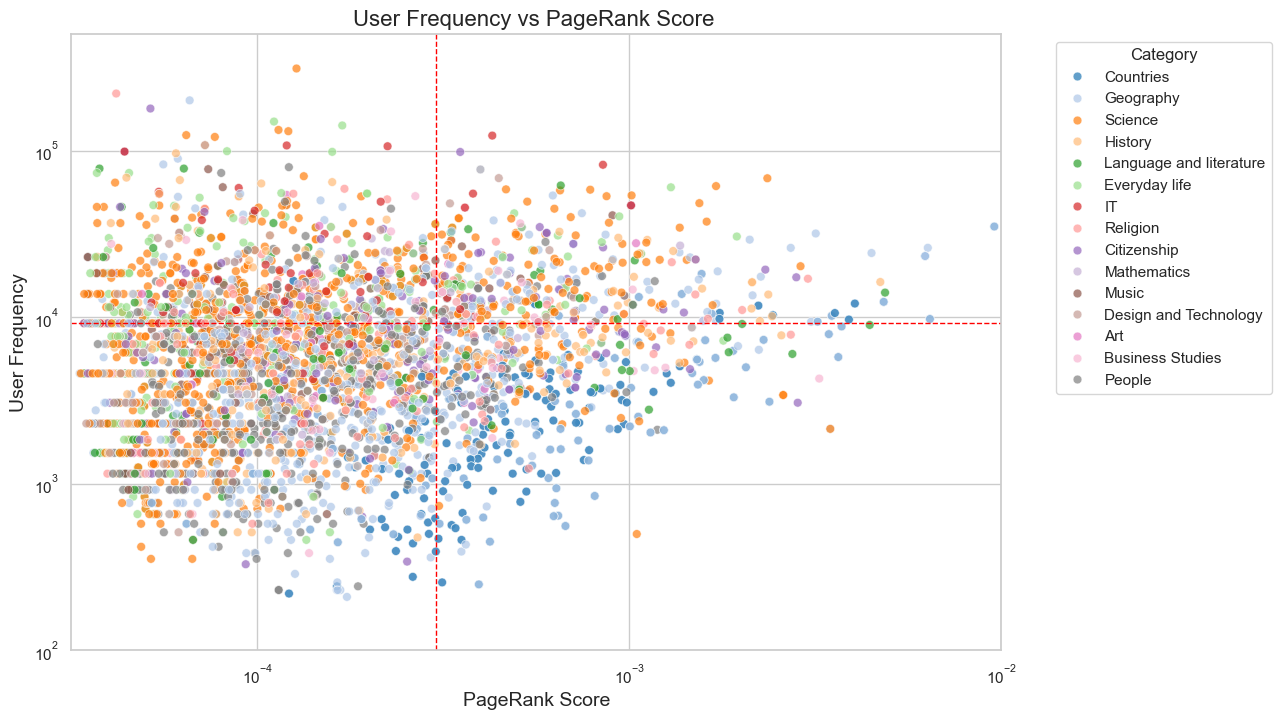

In [25]:
freVpr = get_pageVSfreq_data(data, df_filtered_hubs)
# plot_pageVSfreq(freVpr, category=None) # Interactive plot, obsevations where made on this
plot_pageVSfreq_static(freVpr, category=None)

Due to the fact that most categories are spread out across all quadrants the categories of biggest interest are those that tend to a certain quadrant or have more big outliers than the other ones. The quadrants of interest are the upper left and the lower right quadrants. The first one contains articles that on average is lesser connected yet still highly selected by the players with respect to how often they appear. With the assumption that people in general tend to click more on articles that they know things about, these articles might constitute common knowledge more than other articles. The opposite can be said about the lower right quadrant, which therefore contains articles that might constitute lesser known concepts.

Observations

- Geography is a scattered category that constitutes a large part of the biggest hubs and most frequently used articles by users. However, they also constitute the majority of the more connected articles that does not get used. More specifically, it seems like it is primarily contries that belong to this group, which differs from geography in the sense that the category is very shifted towards the lower right quadrant. Someething that is investigated in the next plot. 
- Science is also very scatterd, with a lot of big outliers in both the upper left and lower right quadrants. 
- Everyday life and IT seems to have some articles that are used more than average by users, yet still on average is less connected than other articles. IT is particularly interesting since its articles are heavily shifted up to the left, with 0 articles in the lower right quadrant. 

(Important not to get hooked on specific outliers since some players also have a good understaning of specific articles that are good for the game)

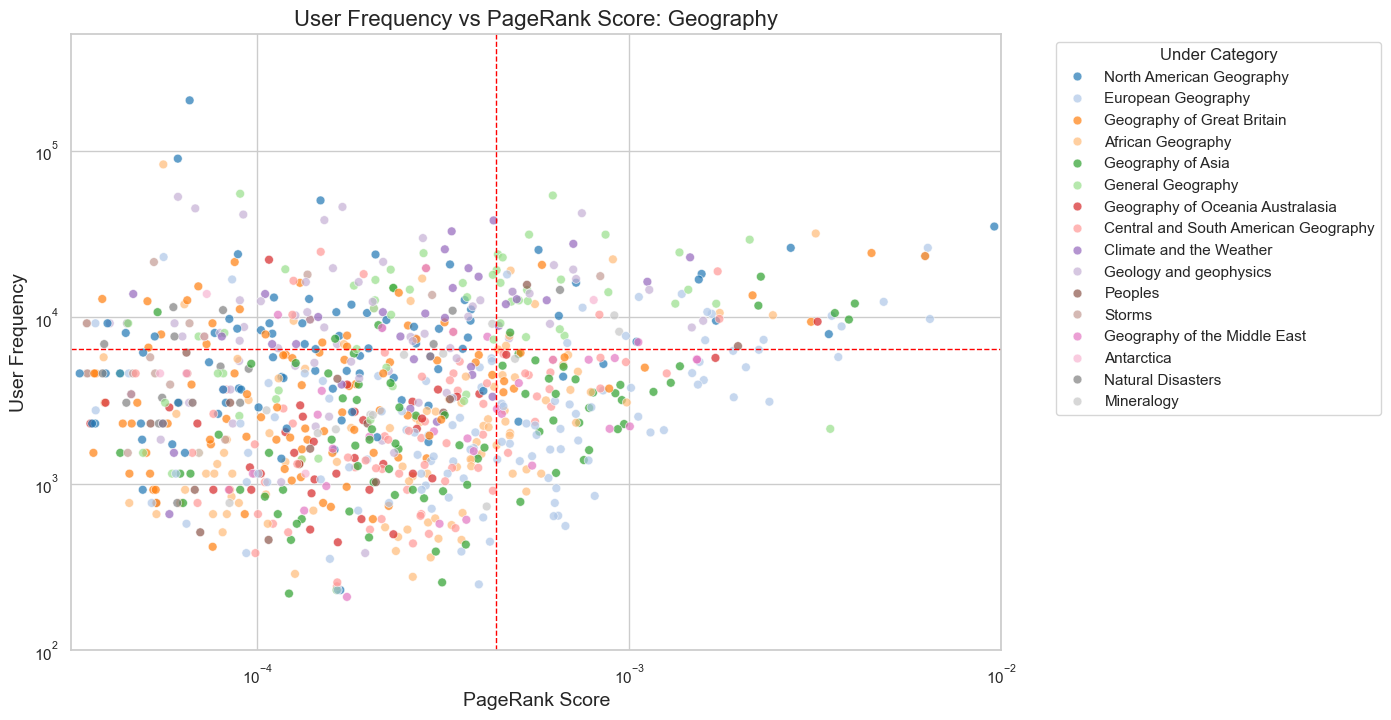

In [26]:
# plot_pageVSfreq(freVpr, category='Geography') # Interactive plot, obsevations where made on this
plot_pageVSfreq_static(freVpr, category='Geography')

Observations
- The categories that have tends towards the upper left quadrant with bigger portion of outliers than other articles are North American Geography, General Geograhpy and Geology and Geophysics. 
- As stated before and can be seen in the first plot, countries constitute the absolute majority of all articles in the lower right quadrant. 

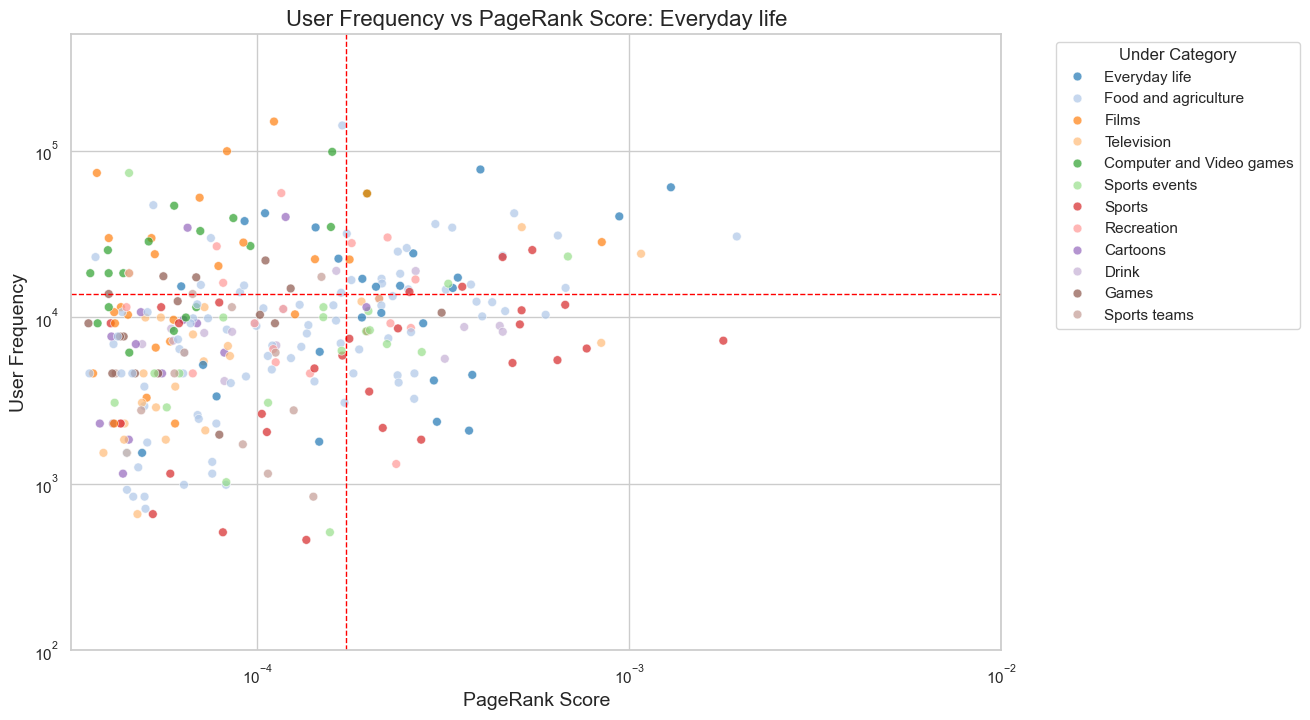

In [27]:
# plot_pageVSfreq(freVpr, category='Everyday life') # Interactive plot, obsevations where made on this
plot_pageVSfreq_static(freVpr, category='Everyday life')

Observation
- The majority of articles with a smaller pagerank score that yet have above average frequency by users belong to the "Film" and "Computer and Video games" categories. Where the articles in question are big popcultural phenomenon such as Star Wars, Nintendo and Mario. Something that is not that suprising that people have good knowledge in. 
- Sports constitutes the biggest part of the articles in "Everyday life" that are in the lower right quadrant. 


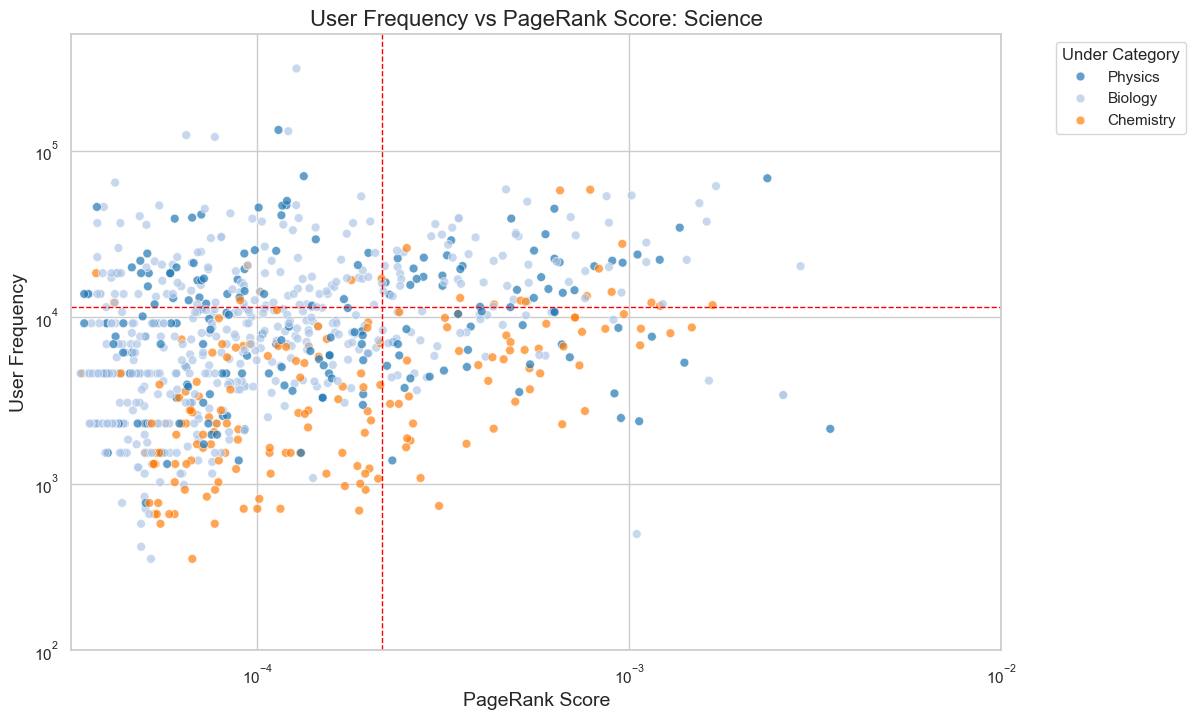

In [28]:
# plot_pageVSfreq(freVpr, category='Science') # Interactive plot, obsevations where made on this
plot_pageVSfreq_static(freVpr, category='Science')

Observations: 
- Chemistry has almost no articles in the upper left quadrant but a lot in the lower right one.
- Physics is heavily scattered. The artiles in the upper left quadrant are almost all space related, while the ones in the lower right quadrant are more low-level physics.
- Biology is also scattered, where animals mostly make up the articles in the upper left quadrant while more low level articles constitute the articles in the lower right column. 

In [29]:
get_quadrant_views(freVpr)


TypeError: Choicelist and default value do not have a common dtype: The DType <class 'numpy.dtypes._PyLongDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyLongDType'>)

In this plot we gathered external data on the average amount of views on wikipedia per month over the last 1o years for all articles. This was then used to calculate the average views for the articles in each quadrant. 

It can be seen that the articles in the lower right quadrant has significally higher views on average than the articles in the upper left. This goes in line with the assumptions made on the 2 quadrants for the 4 plots above, since information looked up on wikipedia is usually not known to the user beforehand. Therefore, the claim that the articles in the upper left quadrant might constitute common knowledge more than the articles in the lower right quadrant is supported (but not proven) by the fact that the articles in the lower right quadrants have more than twice as many visits per month as the articles in the upper left quadrant. 

In [ ]:
matrix1, matrix2, unused_links, article_names = load_fork_matrix(data, df_hubs)

KeyboardInterrupt: 

C:\Users\antoi\AppData\Local\Temp\ipykernel_6064\3689004602.py:6: RuntimeWarning:

invalid value encountered in divide



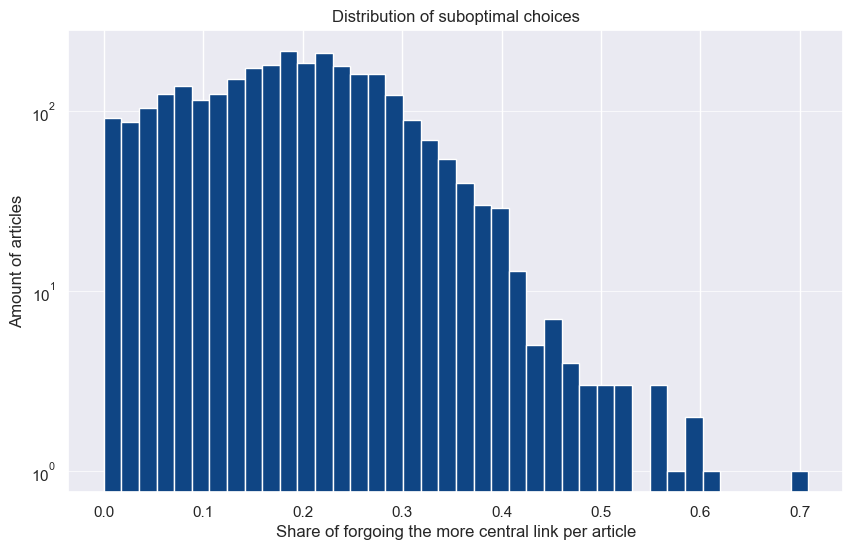

                                    Article  Forgone Value  Column Sums UL
433                                    Bran       0.708333            24.0
2601                          Thomas Edison       0.619048           126.0
1870                           Nikola Tesla       0.595156           289.0
1609                           Lyme disease       0.588889            90.0
196                                Aquarium       0.573248           628.0
2325                          Schizophrenia       0.564286           280.0
1251                     History of science       0.562212           217.0
37                              90377 Sedna       0.550000            20.0
1711                             Meningitis       0.527027            74.0
2037                     Philosophy of mind       0.522124           113.0
1724              Metric expansion of space       0.515152            33.0
966                        Fertile Crescent       0.512635           277.0
1704                     

In [ ]:
df_hubscopy, forgone_articles_df = plot_badChoices(matrix1 + matrix2, unused_links, article_names, df_hubs, data)

This plot illustrates how often users bypass a more central article in favor of a less optimal one, focusing only on cases where alternative articles have the same or shorter shortest-path distance to the target. As expected, users frequently deviate from the optimal navigation path. Notably, some articles are overlooked more frequently than others, suggesting that users are less likely to consider these articles during navigation. Specifically, articles such as "Bran," "Thomas Edison," and "Lyme Disease" appear to be consistently neglected, potentially indicating a lower level of awareness or recognition of these topics among players.

In [ ]:
plot_hubScoreVSforgone(df_hubscopy)


In this approach it can be seen that, the more central an article is the more predictable is the rate at which it is ignored despite leading to the target quicker/ equally quickly and with a higher hub score. This may very well be due to a higher occurance rate of 'hublike' articles. Nevertheless, while exploring the plot some peculiarities occur. Some oddly specific articles are ignored less than the majority. This could result from the general public being more aware of e. g. chemical elements, than 'Lyme disease'. For the article 'Lyme disease' is ignored 59% of the time, which is almost double compared to the article 'Rodium', despite a comparable hub score.

In [ ]:
from src.hubs_frequency import get_hub_positions, plot_hub_positions

finished_hub_positions, unfinished_hub_positions, shortest_hub_positions = get_hub_positions(data, df_hubs)

4604 hubs found 414


C:\Users\antoi\AppData\Local\Temp\ipykernel_6064\4043298409.py:45: RuntimeWarning:

invalid value encountered in divide

C:\Users\antoi\AppData\Local\Temp\ipykernel_6064\4043298409.py:46: RuntimeWarning:

invalid value encountered in divide

C:\Users\antoi\AppData\Local\Temp\ipykernel_6064\4043298409.py:47: RuntimeWarning:

invalid value encountered in divide



nan


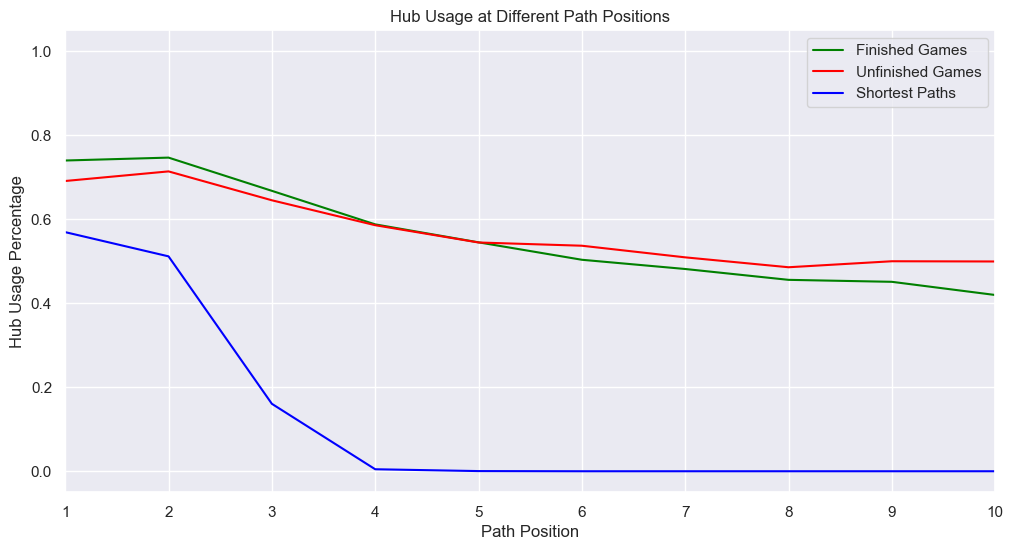

In [ ]:
plot_hub_positions(df_hubs, finished_hub_positions, unfinished_hub_positions, shortest_hub_positions)

This plot reveals that in 50% of puzzles, the optimal strategy is to navigate to one of the top 10% most connected hubs with the first click. Most players tend to use these top hubs in their initial steps. Notably, successful players are more likely to utilize hubs within their first three steps compared to unsuccessful players, suggesting that early use of hubs improves navigation success.

In [ ]:
df_filtered_hubs

,article_names,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path,Art,Business Studies,Citizenship,Countries,Design and Technology,...,Language and literature,Mathematics,Music,People,Religion,Science,pagerank_score,pagerank_outgoing_score,hub_score,pagerank_hub_score_percent
6,10th century,26,65,2.527154,3.086313,0,0,0,0,0,...,0,0,0,0,0,0,0.000632,0.000651,0.000641,0.064106
7,11th century,48,57,2.586041,2.974353,0,0,0,0,0,...,0,0,0,0,0,0,0.000545,0.000603,0.000574,0.057420
8,12th century,45,85,2.552672,2.956350,0,0,0,0,0,...,0,0,0,0,0,0,0.000718,0.000746,0.000732,0.073184
9,13th century,34,84,2.509706,3.108755,0,0,0,0,0,...,0,0,0,0,0,0,0.000755,0.000761,0.000758,0.075781
10,14th century,31,71,2.650600,3.074229,0,0,0,0,0,...,0,0,0,0,0,0,0.000596,0.000617,0.000606,0.060629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,Zionism,74,25,2.794984,2.790875,0,0,0,0,0,...,0,0,0,1,1,0,0.000206,0.000282,0.000244,0.024421
4600,Zirconium,42,15,3.534569,2.975832,0,0,0,0,0,...,0,0,0,0,0,1,0.000088,0.000113,0.000100,0.010024
4601,Zoroaster,28,9,3.007415,3.157090,0,0,0,0,0,...,0,0,0,1,0,0,0.000094,0.000103,0.000099,0.009857
4602,Zuid-Gelders,5,5,3.364013,3.874476,0,0,0,0,0,...,1,0,0,0,0,0,0.000087,0.000044,0.000066,0.006566


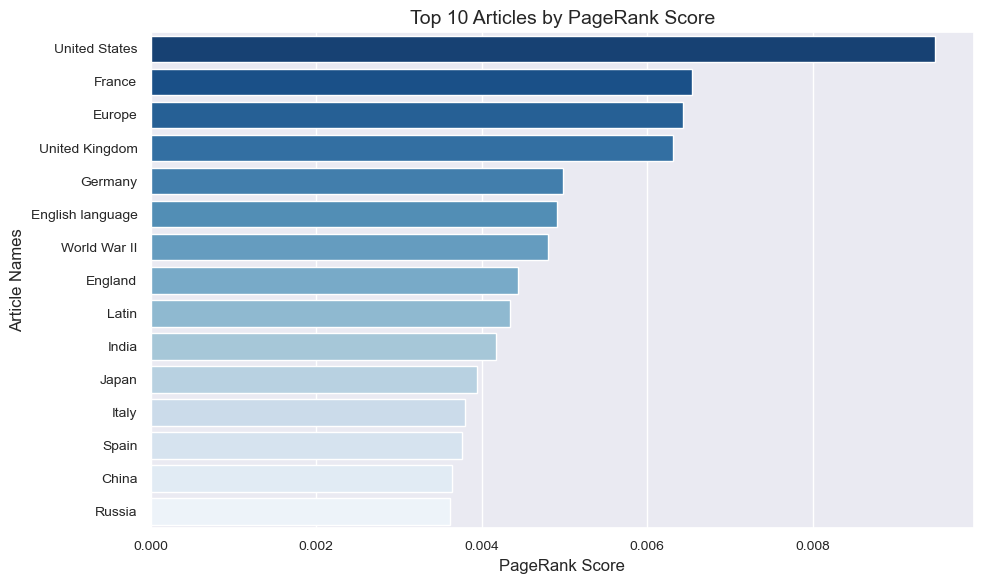

In [ ]:
# Top 10 hubs viz
top_10_pr = df_filtered_hubs.sort_values(by="hub_score", ascending=False).head(15)
inverted_palette = sns.color_palette("Blues", n_colors=15)


#bar plot 
plt.figure(figsize=(10, 6))
bar_plt = sns.barplot(
    data=top_10_pr,
    y="article_names",
    x="hub_score",
    hue="hub_score",
    palette= inverted_palette
)

# Add labels and title
plt.xlabel("PageRank Score", fontsize=12)
plt.ylabel("Article Names", fontsize=12)
plt.title("Top 10 Articles by PageRank Score", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend().remove()
plt.tight_layout()
plt.savefig("top_page_rank_articles.png")
plt.show()



From this chart, we can see that even the top hub scores in the entire graph are still relatively low, with the highest being 'United States' with a score of around .009. We can also see that the top 10 articles with the highest PageRank seem very similar to those most visited articles. 

In [ ]:
# Visualize all articles in 3d space, with size based on hub score

import plotly.graph_objects as go

# Generate positions for articles in 3D space using a random distribution
num_nodes = len(G.nodes())
x_vals = np.random.uniform(-0.2, 0.2, num_nodes)  # size of space
y_vals = np.random.uniform(-0.2, 0.2, num_nodes)  
z_vals = np.random.uniform(-0.2, 0.2, num_nodes)  

# Get PageRank scores and normalize them for point sizes
pagerank_scores = df_hubs.set_index("article_names")["hub_score"].to_dict()
sizes = [pagerank_scores.get(node, 0) * 3000 for node in G.nodes()] 
colors = [pagerank_scores.get(node, 0) for node in G.nodes()]  


# Create a Plotly 3D scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(
        size=sizes,
        color=colors,
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='PageRank Score')
    ),
    text=list(G.nodes()),  # Add node names for hover info
    hoverinfo='text'
))

# Update layout for better visualization
fig.update_layout(
    title='Interactive 3D Visualization of Articles by PageRank',
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    paper_bgcolor='white',  # Blank background
    margin=dict(l=0, r=0, b=0, t=40)
)

# Display the interactive plot
fig.show()


Here we have visualized all the articles in the graph network in space, with each dot representing an article, and the size of the dot being correlated to the value of the PageRank score. From this, we can get an idea of just how large the network is, and how there are not many articles with notable PageRank values, meaning they are not very well connected in the network. 